# Bibliotheken importeren

In [1]:
import pandas as pd 
import pyodbc
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import math

# !!! SKLEARN IS DEPRECATED, PIP INSTALL "scikit-learn" INSTEAD !!!
from sklearn.cluster import KMeans
"""
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
"""

'\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn import tree\nfrom sklearn import metrics\nfrom sklearn.utils.multiclass import unique_labels\nfrom sklearn.metrics import classification_report\n'

# Data inlezen en kolommen selecteren

In [2]:
# !!! HOEFT DIT ALLEEN TE RUNNEN WANNEER DE DATA NOG NIET IN DE SQLITE DATABASE STAAT !!!
def ssms_to_sqlite():
    DB = {'servername': r'LAPTOP-NBUM6TMN',
        'database': 'johari'}

    ssms_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                        ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')
    ssms_cursor = ssms_conn.cursor()

    # Data inlezen van de benodigde tabellen
    returned_item = pd.read_sql("SELECT * FROM rSALES_STAFF", ssms_conn)
    order_details = pd.read_sql("SELECT * FROM SALES_BRANCH", ssms_conn)

    # Naar SQLite database
    sqlite_conn = sqlite3.connect('../data/johari.db')
    returned_item.to_sql('SALES_STAFF', con=sqlite_conn, if_exists='replace', index=False)
    order_details.to_sql('SALES_BRANCH', con=sqlite_conn, if_exists='replace', index=False)

def data_to_sqlite():
    # Data inlezen van de benodigde tabellen
    go_sales_conn = sqlite3.connect('../data/go_sales.sqlite')
    sales_branch = pd.read_sql("SELECT * FROM sales_branch", go_sales_conn)

    # Naar SQLite database
    sqlite_conn = sqlite3.connect('../data/johari.db')
    sales_branch.to_sql('SALES_BRANCH', con=sqlite_conn, if_exists='replace', index=False)

# ssms_to_sqlite()
# data_to_sqlite()

In [3]:
# Lees de data in van de SQLite database
sqlite_conn = sqlite3.connect('../data/johari.db')
go_sales = sqlite3.connect('../data/go_sales.sqlite')
sales_branch = pd.read_sql("SELECT * FROM SALES_BRANCH", sqlite_conn)
country = pd.read_sql("SELECT * FROM COUNTRY", go_sales)

df = sales_branch.loc[:, ['SALES_BRANCH_CODE', 'COUNTRY_CODE', 'CITY']]
df

,SALES_BRANCH_CODE,COUNTRY_CODE,CITY
0,13,2,Hamburg
1,14,2,München
2,15,10,Kista
3,17,4,Calgary
4,18,4,Toronto
5,19,3,Boston
6,20,3,Seattle
7,21,3,Los Angeles
8,22,3,Miami
9,23,1,Lyon


# One-hot encoding van onafhankelijke niet-numerieke variabelen

In [4]:

dummies_dataframe = pd.get_dummies(df.loc[:, ['CITY']]) # One-hot encoding
dummies_dataframe.head()


,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,CITY_Hamburg,CITY_Heverlee,CITY_Kista,CITY_Kuopio,...,CITY_Paris,CITY_San Chung,CITY_Seattle,CITY_Seoul,CITY_Shanghai,CITY_São Paulo,CITY_Tokyo,CITY_Toronto,CITY_Wien,CITY_Zürich
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [5]:

df = pd.concat([df, dummies_dataframe], axis=1) # Dataframes samenvoegen
df = df.drop(columns=['CITY']) # Vervangende kolom verwijderen
df.head()


,SALES_BRANCH_CODE,COUNTRY_CODE,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,CITY_Hamburg,CITY_Heverlee,...,CITY_Paris,CITY_San Chung,CITY_Seattle,CITY_Seoul,CITY_Shanghai,CITY_São Paulo,CITY_Tokyo,CITY_Toronto,CITY_Wien,CITY_Zürich
0,13,2,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,14,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,15,10,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,17,4,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,18,4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


# Clusteringmodel bouwen met 2 dimensies

In [6]:
df_2d = df.loc[:, ['SALES_BRANCH_CODE', 'COUNTRY_CODE']]

df_2d['SALES_BRANCH_CODE'] = df_2d['SALES_BRANCH_CODE'].astype(float)
df_2d['COUNTRY_CODE'] = df_2d['COUNTRY_CODE'].astype(float)

df_2d.head()

,SALES_BRANCH_CODE,COUNTRY_CODE
0,13.0,2.0
1,14.0,2.0
2,15.0,10.0
3,17.0,4.0
4,18.0,4.0


In [7]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit_predict(df_2d)

array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1])

In [8]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1
0,31.800000,13.800000
1,10.666667,4.666667
2,20.000000,3.000000


In [9]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})
    
kmeans_centra

,SALES_BRANCH_CODE,COUNTRY_CODE
0,31.800000,13.800000
1,10.666667,4.666667
2,20.000000,3.000000


In [10]:
for src_index, _ in df_2d.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df_2d.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df_2d.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df_2d

Afstand van bronindex 0 tot...
	Centrumindex 0:
		13.0 - 31.8 = -18.8
		2.0 - 13.8 = -11.8
	Totale euclidische som: 492.68000000000006
	Euclidische afstand: 22.19639610387236
------------------------------------------------
	Centrumindex 1:
		13.0 - 10.666666666666668 = 2.333333333333332
		2.0 - 4.666666666666667 = -2.666666666666667
	Totale euclidische som: 12.555555555555552
	Euclidische afstand: 3.543381937578216
------------------------------------------------
	Centrumindex 2:
		13.0 - 20.0 = -7.0
		2.0 - 3.0 = -1.0
	Totale euclidische som: 50.0
	Euclidische afstand: 7.0710678118654755
------------------------------------------------
{0: 22.19639610387236, 1: 3.543381937578216, 2: 7.0710678118654755}
1
Afstand van bronindex 1 tot...
	Centrumindex 0:
		14.0 - 31.8 = -17.8
		2.0 - 13.8 = -11.8
	Totale euclidische som: 456.08000000000004
	Euclidische afstand: 21.35602959353634
------------------------------------------------
	Centrumindex 1:
		14.0 - 10.666666666666668 = 3.33333333333

,SALES_BRANCH_CODE,COUNTRY_CODE,Centrum
0,13.0,2.0,1.0
1,14.0,2.0,1.0
2,15.0,10.0,1.0
3,17.0,4.0,2.0
4,18.0,4.0,2.0
5,19.0,3.0,2.0
6,20.0,3.0,2.0
7,21.0,3.0,2.0
8,22.0,3.0,2.0
9,23.0,1.0,2.0


c:\Users\noah\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\noah\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\noah\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

ValueError: x and y must be the same size

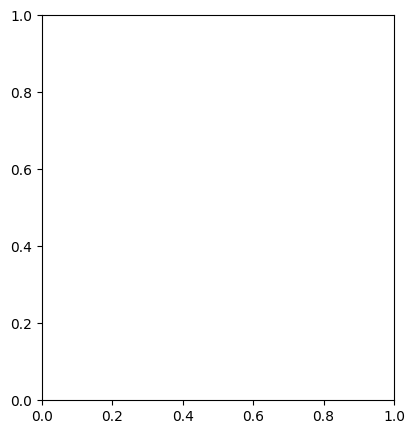

In [53]:
# Interclusterafstand
for i in kmeans_centra.index:
    for j in kmeans_centra.index:
        if i != j:
            diff = kmeans_centra.loc[i] - kmeans_centra.loc[j]
            dist = np.sqrt(np.sum(diff**2))
            print(f"Interclusterafstand tussen cluster {i} en cluster {j}: {dist}")

# Intraclusterafstand
for i in kmeans_centra.index:
    cluster_points = df_2d[df_2d['Centrum'] == i]
    distances = []
    for _, point in cluster_points.iterrows():
        diff = point[:-1] - kmeans_centra.loc[i]
        dist = np.sqrt(np.sum(diff**2))
        distances.append(dist)
    avg_distance = np.mean(distances)
    print(f"Gemiddelde intraclusterafstand voor cluster {i}: {avg_distance}")

# Plot de clusters
plt.scatter(df_2d['SALES_BRANCH_CODE'], df_2d['COUNTRY_CODE'], c = kmeans.labels_, cmap = 'rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'black')
plt.xlabel('SALES_BRANCH_CODE')
plt.ylabel('COUNTRY_CODE')
plt.title('KMeans Clustering')
plt.show()

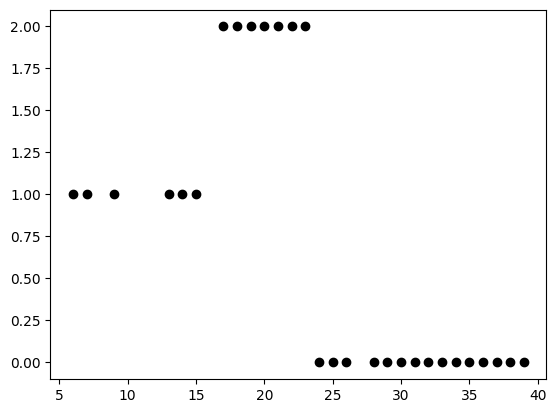

In [11]:
plt.scatter(df_2d['SALES_BRANCH_CODE'], df_2d['Centrum'], color = 'k')
plt.show()

In [12]:
df_2d.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,15
1,6
2,7


# Cluster Model bouwen met meer dan 2 Dimensions

In [13]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([1, 2, 5, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 3, 3,
       3, 4, 3, 1, 1, 1])

In [14]:
df['Cluster'] = prediction_results
df.head()

,SALES_BRANCH_CODE,COUNTRY_CODE,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,CITY_Hamburg,CITY_Heverlee,...,CITY_San Chung,CITY_Seattle,CITY_Seoul,CITY_Shanghai,CITY_São Paulo,CITY_Tokyo,CITY_Toronto,CITY_Wien,CITY_Zürich,Cluster
0,13,2,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,1
1,14,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
2,15,10,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,5
3,17,4,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,2
4,18,4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,2


In [15]:
df.groupby('Cluster', as_index = False)['Cluster'].count()

,Cluster
0,7
1,4
2,8
3,4
4,4
5,1


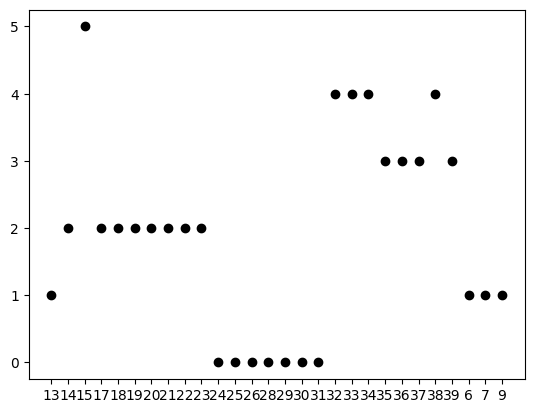

In [24]:
plt.scatter(df['SALES_BRANCH_CODE'], df['Cluster'], color = 'k')
plt.show()

# Merge Sales staff and Branch

In [41]:
# Lees de data in van de SQLite database
sqlite_conn = sqlite3.connect('../data/johari.db')
go_sales = sqlite3.connect('../data/go_sales.sqlite')
sales_branch = pd.read_sql("SELECT * FROM SALES_BRANCH", sqlite_conn)
country = pd.read_sql("SELECT * FROM COUNTRY", go_sales)

df = sales_branch.loc[:, ['SALES_BRANCH_CODE', 'COUNTRY_CODE', 'CITY']]
df

,SALES_BRANCH_CODE,COUNTRY_CODE,CITY
0,13,2,Hamburg
1,14,2,München
2,15,10,Kista
3,17,4,Calgary
4,18,4,Toronto
5,19,3,Boston
6,20,3,Seattle
7,21,3,Los Angeles
8,22,3,Miami
9,23,1,Lyon


In [44]:
# Lees de data in van de SQLite database
sqlite_conn = sqlite3.connect('../data/johari.db')
go_sales = sqlite3.connect('../data/go_sales.sqlite')
sales_branch = pd.read_sql("SELECT * FROM SALES_BRANCH", sqlite_conn)
sales_staff = pd.read_sql("SELECT * FROM SALES_STAFF", sqlite_conn)
country = pd.read_sql("SELECT * FROM COUNTRY", go_sales)

df = sales_staff.loc[:, ['sales_staff_sales_branch_id', 'sales_staff_country_id', 'sales_staff_sales_branch_city']]
df

,sales_staff_sales_branch_id,sales_staff_country_id,sales_staff_sales_branch_city
0,6,1,Paris
1,6,1,Paris
2,6,1,Paris
3,6,1,Paris
4,13,2,Hamburg
...,...,...,...
97,38,17,Heverlee
98,38,17,Heverlee
99,38,17,Heverlee
100,39,5,Wien


In [45]:

dummies_dataframe = pd.get_dummies(df.loc[:, ['sales_staff_sales_branch_city']]) # One-hot encoding
dummies_dataframe.head()


,sales_staff_sales_branch_city_Amsterdam,sales_staff_sales_branch_city_Bilbao,sales_staff_sales_branch_city_Birmingham,sales_staff_sales_branch_city_Boston,sales_staff_sales_branch_city_Calgary,sales_staff_sales_branch_city_Distrito Federal,sales_staff_sales_branch_city_Hamburg,sales_staff_sales_branch_city_Heverlee,sales_staff_sales_branch_city_Kista,sales_staff_sales_branch_city_Kuopio,...,sales_staff_sales_branch_city_Paris,sales_staff_sales_branch_city_San Chung,sales_staff_sales_branch_city_Seattle,sales_staff_sales_branch_city_Seoul,sales_staff_sales_branch_city_Shanghai,sales_staff_sales_branch_city_São Paulo,sales_staff_sales_branch_city_Tokyo,sales_staff_sales_branch_city_Toronto,sales_staff_sales_branch_city_Wien,sales_staff_sales_branch_city_Zürich
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [46]:

df = pd.concat([df, dummies_dataframe], axis=1) # Dataframes samenvoegen
df = df.drop(columns=['sales_staff_sales_branch_city']) # Vervangende kolom verwijderen
df.head()


,sales_staff_sales_branch_id,sales_staff_country_id,sales_staff_sales_branch_city_Amsterdam,sales_staff_sales_branch_city_Bilbao,sales_staff_sales_branch_city_Birmingham,sales_staff_sales_branch_city_Boston,sales_staff_sales_branch_city_Calgary,sales_staff_sales_branch_city_Distrito Federal,sales_staff_sales_branch_city_Hamburg,sales_staff_sales_branch_city_Heverlee,...,sales_staff_sales_branch_city_Paris,sales_staff_sales_branch_city_San Chung,sales_staff_sales_branch_city_Seattle,sales_staff_sales_branch_city_Seoul,sales_staff_sales_branch_city_Shanghai,sales_staff_sales_branch_city_São Paulo,sales_staff_sales_branch_city_Tokyo,sales_staff_sales_branch_city_Toronto,sales_staff_sales_branch_city_Wien,sales_staff_sales_branch_city_Zürich
0,6,1,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,6,1,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,6,1,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,6,1,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,13,2,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4])

In [48]:
df['Cluster'] = prediction_results
df.head()

,sales_staff_sales_branch_id,sales_staff_country_id,sales_staff_sales_branch_city_Amsterdam,sales_staff_sales_branch_city_Bilbao,sales_staff_sales_branch_city_Birmingham,sales_staff_sales_branch_city_Boston,sales_staff_sales_branch_city_Calgary,sales_staff_sales_branch_city_Distrito Federal,sales_staff_sales_branch_city_Hamburg,sales_staff_sales_branch_city_Heverlee,...,sales_staff_sales_branch_city_San Chung,sales_staff_sales_branch_city_Seattle,sales_staff_sales_branch_city_Seoul,sales_staff_sales_branch_city_Shanghai,sales_staff_sales_branch_city_São Paulo,sales_staff_sales_branch_city_Tokyo,sales_staff_sales_branch_city_Toronto,sales_staff_sales_branch_city_Wien,sales_staff_sales_branch_city_Zürich,Cluster
0,6,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
1,6,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
2,6,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3,6,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
4,13,2,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,2


In [49]:
df.groupby('Cluster', as_index = False)['Cluster'].count()

,Cluster
0,36
1,10
2,11
3,19
4,14
5,12


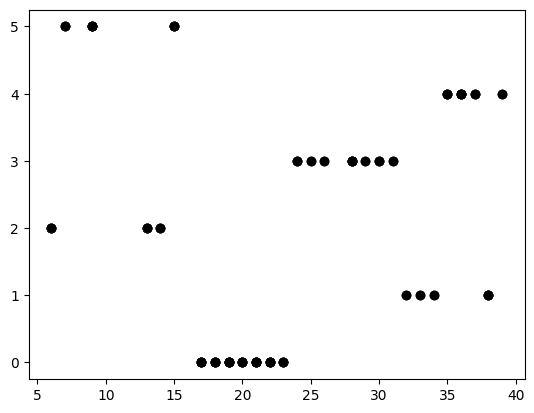

In [51]:
plt.scatter(df['sales_staff_sales_branch_id'], df['Cluster'], color = 'k')
plt.show()